In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from beartype import beartype as typed
from datasets import load_dataset
from jaxtyping import Float, Int
from typing import Callable
from torch import Tensor as TT
from transformers import AutoModelForCausalLM, AutoTokenizer

%load_ext autoreload
%autoreload 2

In [2]:
model = AutoModelForCausalLM.from_pretrained("Mlxa/brackets-nested")
tokenizer = AutoTokenizer.from_pretrained("Mlxa/brackets-nested")

In [92]:
import re

@typed
def gauss_helper(a: TT | tuple) -> TT | tuple:
    if isinstance(a, tuple):
        return tuple(gauss_helper(x) for x in a)
    else:
        assert a.numel() > 2
        mean = a.mean()
        std = a.std()
        return 0 * (t.randn_like(a) * std + mean)

@typed
def gauss_hook(module: nn.Module, _input: TT | tuple, output: TT | tuple) -> TT | tuple:
    return gauss_helper(output)

class Hooks:
    @typed
    def __init__(self, module: nn.Module, filter: Callable[[str], bool], hook: Callable[[nn.Module, TT, TT], TT]) -> None:
        self.handles = []
        self.module = module
        for name, submodule in module.named_modules():
            if filter(name):
                # print(name, "hooked")
                self.handles.append(submodule.register_forward_hook(hook))
    
    @typed
    def __enter__(self) -> nn.Module:
        return self.module
    
    @typed
    def __exit__(self, *_) -> None:
        for handle in self.handles:
            handle.remove()


In [3]:
from utils import generate_sample, get_loss, tokenize, get_logprobs


@typed
def nested_prompt(n: int) -> str:
    openning = " ".join(f"<{i}" for i in range(1, n + 1))
    closing = " ".join(f"{i}>" for i in range(n, 0, -1))
    return openning + " " + closing

@typed
def loss_metric(model: nn.Module, tokenizer, n: int) -> float:
    prompt = nested_prompt(n)
    return get_loss(model, tokenizer, prompt) * n

@typed
def accuracy_metric(model: nn.Module, tokenizer, n: int) -> float:
    prompt = nested_prompt(n)
    ids = tokenize(tokenizer, prompt)["input_ids"][0]
    lp = get_logprobs(model, tokenizer, prompt)
    mx = lp.argmax(dim=-1)
    correct = mx == ids
    assert correct.shape == (2 * n,)
    return correct[n:].float().mean().item()

@typed
def max_correct(model: nn.Module, tokenizer) -> int:
    l, r = 0, 64
    while r - l > 1:
        m = (l + r) // 2
        if accuracy_metric(model, tokenizer, m) > 1 - 1e-9:
            l = m
        else:
            r = m
    return l

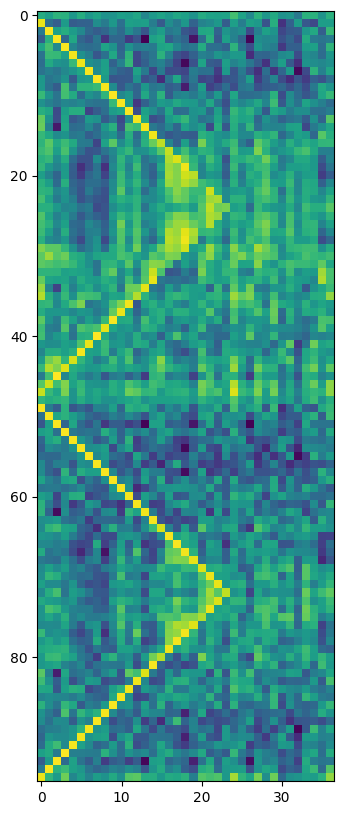

In [32]:
n = 24
prompt = nested_prompt(n) + " " + nested_prompt(n)
lp = get_logprobs(model, tokenizer, prompt)
plt.figure(figsize=(10, 10))
plt.imshow(lp[:, 1 : 3* (n + 1) : 2])
plt.savefig("img/observed.svg")

In [270]:
from collections import defaultdict

all_module_names = [
    ".".join(name.split(".")[:-1]) for name in model.state_dict().keys()
]
all_module_names = sorted(list(set(all_module_names)))
ns = [4, 8, 16, 24, 32]
results = defaultdict(list)
baselines = {n: loss_metric(model, tokenizer, n) for n in ns}

for name in all_module_names:
    for n in ns:
        with Hooks(model, lambda x: x == name, gauss_hook) as hooked:
            results[name].append(loss_metric(hooked, tokenizer, n) - baselines[n])
    print(name, results[name])

lm_head [12.72193717956543, 23.6521053314209, 41.880531311035156, 42.88937759399414, 35.908416748046875]
transformer.h.0.attn.attention.k_proj [1.5446062088012695, 1.3048477172851562, 1.8312530517578125, -0.48790740966796875, 0.5988006591796875]
transformer.h.0.attn.attention.out_proj [18.735538482666016, 32.247182846069336, 69.03973388671875, 88.65131378173828, 107.03175354003906]
transformer.h.0.attn.attention.q_proj [1.5446062088012695, 1.3048477172851562, 1.8312530517578125, -0.48790740966796875, 0.5988006591796875]
transformer.h.0.attn.attention.v_proj [20.24831771850586, 51.756425857543945, 94.49577331542969, 120.15218353271484, 142.19187927246094]
transformer.h.0.ln_1 [20.24831771850586, 51.756425857543945, 94.49577331542969, 120.15218353271484, 142.19187927246094]
transformer.h.0.ln_2 [0.1554584503173828, 4.603397369384766, 43.11750793457031, 50.2056999206543, 53.174407958984375]
transformer.h.0.mlp.c_fc [0.1218404769897461, 5.505771636962891, 46.03436279296875, 53.611804962158

In [271]:
for name in all_module_names:
    for n in ns:
        with Hooks(model, lambda x: x == name, gauss_hook) as hooked:
            results[name] = max_correct(hooked, tokenizer)
    print(name, results[name])

lm_head 0
transformer.h.0.attn.attention.k_proj 15
transformer.h.0.attn.attention.out_proj 0
transformer.h.0.attn.attention.q_proj 15
transformer.h.0.attn.attention.v_proj 0
transformer.h.0.ln_1 0
transformer.h.0.ln_2 8
transformer.h.0.mlp.c_fc 8
transformer.h.0.mlp.c_proj 8
transformer.h.1.attn.attention.k_proj 3
transformer.h.1.attn.attention.out_proj 2
transformer.h.1.attn.attention.q_proj 3
transformer.h.1.attn.attention.v_proj 2
transformer.h.1.ln_1 2
transformer.h.1.ln_2 9
transformer.h.1.mlp.c_fc 10
transformer.h.1.mlp.c_proj 10
transformer.h.2.attn.attention.k_proj 9
transformer.h.2.attn.attention.out_proj 12
transformer.h.2.attn.attention.q_proj 9
transformer.h.2.attn.attention.v_proj 12
transformer.h.2.ln_1 12
transformer.h.2.ln_2 7
transformer.h.2.mlp.c_fc 6
transformer.h.2.mlp.c_proj 6
transformer.h.3.attn.attention.k_proj 16
transformer.h.3.attn.attention.out_proj 13
transformer.h.3.attn.attention.q_proj 16
transformer.h.3.attn.attention.v_proj 13
transformer.h.3.ln_1 13
t

In [151]:
for name, values in results.items():
    x = np.array(ns)
    y = np.array(values)
    A = np.vstack([x, np.ones(len(x))]).T
    k, b = np.linalg.lstsq(A, y, rcond=None)[0]
    unexplained = np.square(y - (k * x + b)).mean() ** 0.5
    if k > 2.0:
        print(name, " " * (40 - len(name)), b, k)

transformer.h.0.attn.attention.out_proj   9.157332083074044 3.2133197871650134
transformer.h.0.attn.attention.v_proj     14.183864535354967 4.261014964522386
transformer.h.0.ln_1                      14.183864535354967 4.261014964522386
transformer.h.0.ln_2                      -4.729656359044528 2.082199445584925
transformer.h.0.mlp.c_fc                  -6.219307573830216 2.358592649785484
transformer.h.0.mlp.c_proj                -6.9098697987998605 2.495550713888029
transformer.h.1.attn.attention.k_proj     -5.85573838396771 2.077788905399602
transformer.h.1.attn.attention.q_proj     -5.85573838396771 2.077788905399602
transformer.h.6.attn.attention.out_proj   -4.390994106850984 2.008239952529349
transformer.h.7.attn.attention.out_proj   -1.8989629396578165 2.7899494490972376
transformer.h.7.attn.attention.v_proj     -1.9572087846151327 2.786851664868797
transformer.h.7.ln_1                      -1.9572087846151327 2.786851664868797
transformer.h.7.ln_2                      -0.1597

In [241]:
layers = ["2.", "3.", "4.", "5.", "6."]


def low_rank_approximation(f: float = 1.0, d: float = 0.0) -> nn.Module:
    new_model = AutoModelForCausalLM.from_pretrained("Mlxa/brackets-nested")
    for name, param in new_model.named_parameters():
        if param.ndim != 2:
            continue
        U, S, Vh = t.linalg.svd(param.data, full_matrices=False)
        pref = 0
        while S[:pref].sum() < min(f * S.sum(), S.sum() - d):
            pref += 1
        S[pref:] = 0
        print(name, pref, "out of", S.size(0))
        param.data = U @ t.diag(S) @ Vh
    return new_model

In [245]:
lora = low_rank_approximation(f=1.0, d=60.0)
for n in ns:
    print(n, loss_metric(lora, tokenizer, n), baselines[n])

transformer.wte.weight 193 out of 256
transformer.wpe.weight 171 out of 256
transformer.h.0.attn.attention.k_proj.weight 88 out of 256
transformer.h.0.attn.attention.v_proj.weight 39 out of 256
transformer.h.0.attn.attention.q_proj.weight 101 out of 256
transformer.h.0.attn.attention.out_proj.weight 58 out of 256
transformer.h.0.mlp.c_fc.weight 160 out of 256
transformer.h.0.mlp.c_proj.weight 144 out of 256
transformer.h.1.attn.attention.k_proj.weight 62 out of 256
transformer.h.1.attn.attention.v_proj.weight 82 out of 256
transformer.h.1.attn.attention.q_proj.weight 62 out of 256
transformer.h.1.attn.attention.out_proj.weight 95 out of 256
transformer.h.1.mlp.c_fc.weight 170 out of 256
transformer.h.1.mlp.c_proj.weight 136 out of 256
transformer.h.2.attn.attention.k_proj.weight 35 out of 256
transformer.h.2.attn.attention.v_proj.weight 75 out of 256
transformer.h.2.attn.attention.q_proj.weight 34 out of 256
transformer.h.2.attn.attention.out_proj.weight 80 out of 256
transformer.h.2.m

In [2]:
@typed
def analyze_orthonormality(model: nn.Module) -> None:
    embs = model.get_input_embeddings().weight.detach()
    norms = embs.norm(dim=-1)
    print(f"norms: {norms.mean().item():.3f} ± {norms.std().item():.3f}")
    A = embs @ embs.T
    print(f"covariance: {A.mean().item():.3f}, variance: {A.diag().mean().item():.3f}")


analyze_orthonormality(AutoModelForCausalLM.from_pretrained("Mlxa/brackets-nested"))
analyze_orthonormality(AutoModelForCausalLM.from_pretrained("Mlxa/brackets-flat"))
analyze_orthonormality(AutoModelForCausalLM.from_pretrained("Mlxa/brackets-flat_shuffle"))
analyze_orthonormality(AutoModelForCausalLM.from_pretrained("roneneldan/TinyStories-8M"))

norms: 3.600 ± 1.313
covariance: 0.650, variance: 14.683
norms: 3.702 ± 1.129
covariance: 0.188, variance: 14.974
norms: 4.054 ± 1.230
covariance: 0.063, variance: 17.944
norms: 0.796 ± 0.293
covariance: 0.164, variance: 0.719
